Copyright © 2024 Xiaohan Dan(xiaohan.dan@yale.edu), Saurabh Baswaraj Shivpuje(sshivpuj@purdue.edu), Yuchen Wang(wang3602@purdue.edu)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Tutorial on quantum algorithm with the Lindblad Master Equation

Here, we provide the code for a general quantum algorithm simulating open quantum dynamics described by the Kraus operators on IBM quantum simulator QASM. This code allows you to choose your Kraus operators and initial density matrix, these are the two only input requirement. The example discussed in this code is the amplitude damping model. For detailed explanations, please refer our works: Sci Rep 10, 3301 (2020)https://doi.org/10.1038/s41598-020-60321-x And Quantum 6, 726 (2022)https://doi.org/10.22331/q-2022-05-30-726. The python and IBM qiskit codes of algorithm involved in implementing the Kraus operators are included in the following order:   

1. Importing libraries
2. Accepting inputs
3. 2-dilation function
4. QASM simulation
5. Plotting the simulation results


# Importing Libraries
The four major libraries imported for this code are:
* "numpy" for all matrix related numerical calculations
* "scipy" for calculating square root of matrix
* "matplotlib" for generating plots from results obtained
* "qiskit" for all types of quantum implementation

In [ ]:
!pip install qiskit==1.0.2
!pip install qiskit_aer==0.14.0.1
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 35.1 MB/s eta 0:00:00


# Simulating the Lindblad Master Equation on Digital Computers

## Definition of Matrix Exponential Propagation and QuTiP solver

In [ ]:
import numpy as np
import scipy.linalg as LA
"""
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - rho0: Initial density matrix (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators (numpy array of shape (N, N)).
    - observable: Observable for which the expectation value is computed (numpy array of shape (N, N)).
    - IsGt: Boolean variable that determines whether to output the propagator list
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
def matrix_expo_prop(H, rho0, time_arr, L, observable, IsGt=False):
    Nsys = H.shape[0]
    ident_h = np.eye(Nsys, dtype=np.complex_)

    # Amatrix for time-derivation of the vectorized density matrix
    Amat = -1j * (np.kron(H, ident_h) - np.kron(ident_h, H.T))
    for i in range(len(L)):
      Amat += 0.5 * (2.0 * (np.kron(L[i], L[i].conj()))
                           - np.kron(ident_h, L[i].T @ L[i].conj())
                           - np.kron(L[i].T.conj() @ L[i], ident_h))

    vec_rho0 = rho0.reshape(Nsys**2)
    expec_vals = []

    if(IsGt): G_prop = []
    for t in time_arr:
        Gt = LA.expm(Amat * t)
        if(IsGt): G_prop.append(Gt)
        vec_rhot = Gt @ vec_rho0
        rhot = vec_rhot.reshape(Nsys, Nsys)
        expec_vals.append(np.trace(rhot @ observable).real)

    if(IsGt):
      return expec_vals, G_prop
    else:
      return expec_vals

In [ ]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect


## The Spin-1/2 system

In [ ]:
# Pauli matrices
sigmax = np.array([[0, 1], [1, 0]], dtype=np.complex_)
sigmaz = np.array([[1, 0], [0, -1]], dtype=np.complex_)
sigmay = np.array([[0, -1j], [1j, 0]], dtype=np.complex_)
ident = np.eye(2, dtype=np.complex_)

# Spin-up and spin-down states
spin_up = np.array([1.0, 0.0], dtype=np.float_)
spin_down = np.array([0.0, 1.0], dtype=np.float_)

# The Spin-1/2 system Hamiltonian
H_1spin = 2 * np.pi * 0.1 * sigmax

# The jump operator and damping rate of Spin-1/2 system
gamma_1spin = 0.05
L_1spin = np.sqrt(gamma_1spin)*sigmax.copy()

# Initial density matrix
rho0_1spin = np.outer(spin_up, spin_up.conj())

# Time step and number of steps
dt = 0.1
nsteps = 250
time_arr = np.linspace(0, (nsteps - 1) * dt, nsteps)

# Matrix Exponential Propagation
expec_vals_matrix_exp = matrix_expo_prop(H_1spin, rho0_1spin, time_arr, [L_1spin], sigmaz)

# QuTiP Propagation for Liouville equation (no collapse operator)
expec_vals_qutip_Liouv = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [], Qobj(sigmaz))

# QuTiP Propagation for Lindblad equation
expec_vals_qutip_Lindblad = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [Qobj(L_1spin)], Qobj(sigmaz))

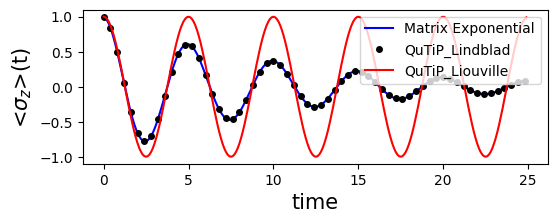

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.plot(time_arr, expec_vals_matrix_exp,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel('<$\sigma^z$>(t)',fontsize=15)
plt.legend(loc = 'upper right')

##The spin-chain

### The system Hamiltonian and initial state

In [ ]:
#the system Hamiltonian parameter
nsite = 3 #this states how many spins in the simulation
Nsys_sc = 2**nsite #this is the dimension of the Hilbert space
Omegai_list = [0.65, 1.0, 1.0]
Jix_list = [0.75, 1.0]
Jiy_list = [0.75, 1.0]
Jiz_list = [0.0, 0.0]

#set up the initial state at [up,down,down...]
init_state = spin_up.copy()
for i in range(nsite-1):
  init_state = np.kron(init_state,spin_down)

#set up the initial density matrix according to initial state
rho0_sc = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
rho0_sc += np.outer(init_state,init_state.conj())

In [ ]:
#the diagnoal part of the Hamiltonian
H_diag = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
for n in range(nsite):
    tmp = 1.0
    for i in range(nsite):
      if(i==n):
        tmp = np.kron(tmp,sigmaz)
      else:
        tmp = np.kron(tmp,ident)
    H_diag += Omegai_list[n]*tmp
#the non-diagnoal (coupling) part of the Hamiltonian
H_coup = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
XX = np.kron(sigmax,sigmax)
YY = np.kron(sigmay,sigmay)
ZZ = np.kron(sigmaz,sigmaz)
for n in range(nsite-1):
  coup_tmp = Jix_list[n]*XX+Jiy_list[n]*YY+Jiz_list[n]*ZZ
  tmp = 1.0
  for i in range(nsite-1):
    if(n==i):
      tmp = np.kron(tmp,coup_tmp)
    else:
      tmp = np.kron(tmp,ident.copy())
  H_coup += tmp
Hsys_sc = H_diag - 0.5 * H_coup
Hsys_sc_qobj = Qobj(Hsys_sc)

### Setup the Lindbladian

In [ ]:
#The lindblad damping rate
Gamma1 = [0.016]*nsite
Gamma2 = [0.0523]*nsite

#The Collapse operators
L_sc = []
L_sc_qobj = [] #this stores Qobj type for QuTiP methods

sigmap = (sigmax+1j*sigmay)*0.5
sigmam = (sigmax-1j*sigmay)*0.5
sigma2 = sigmap@sigmam

for isite in range(nsite):
  #Lindbladian for type 1
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,sigmam)*np.sqrt(Gamma1[isite])
    else:
      res = np.kron(res,ident)
  L_sc.append(res)
  L_sc_qobj.append(Qobj(res))

  #Lindbladian for type 2
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,sigma2)*np.sqrt(Gamma2[isite])
    else:
      res = np.kron(res,ident)
  L_sc.append(res)
  L_sc_qobj.append(Qobj(res))

### Spin-chain Dynamics: Matrix Exponential Propagation and QuTiP solver

In [ ]:
# Matrix Exponential Propagation
result_matrix_exp, Gprop_sc = matrix_expo_prop(Hsys_sc, rho0_sc, time_arr, L_sc, rho0_sc, IsGt=True)

rho0_sc_qobj = Qobj(rho0_sc)
# QuTiP Propagation for Liouville equation (no collapse operator)
result_qutip_Liouv = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, [], rho0_sc_qobj)

# QuTiP Propagation for Lindblad equation
result_qutip_Lindblad = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, L_sc_qobj, rho0_sc_qobj)

As_matrix_exp = np.sqrt(result_matrix_exp)
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])

### Plot the Spin-chain dynamics

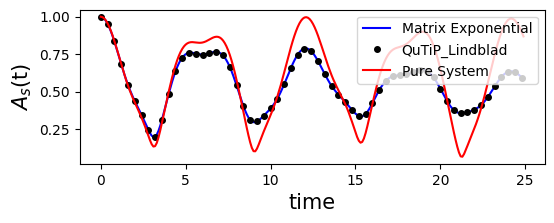

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_matrix_exp,'b-', label="Matrix Exponential")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP_Lindblad")
plt.plot(time_arr,As_qutip_liouv,'r-',label="Pure System")
plt.xlabel('time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Double Well

###SOFT to do the propogation

In [ ]:
def get_doublewell_potential(x, x0=1.9592, f=0.0367493, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/x0
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

In [ ]:
def get_coherent_state(x, p_0, x_0, mass=1, omega=1, hbar=1):
    # coherent state in position representation
    normalization = (mass * omega / np.pi / hbar)**(0.25)
    y = normalization * np.exp(-1*(mass * omega / hbar / 2)*((x - x_0)**2)+1j*p_0*x/hbar)
    return y

In [ ]:
def pot_harmionic(x,mass,omega):
  return 0.5*mass*omega**2*x**2

In [ ]:
import scipy.fft as sfft

#set up the initial value
mass0 = 1836.15
omega = 0.00436013 #a.u., which is 956.939 cm^{-1}
x0_wave = 2.9388   #initial position 1.9592*1.5
hbar = 1.0

#set up the grid
xmin = -4.0
xmax = 4.0
ndvr_x = 1024
dx = (xmax-xmin)/(ndvr_x-1)
dk = 2.0*np.pi/((ndvr_x)*dx)
xgrid = np.zeros(ndvr_x,dtype=np.float64)
kgrid = np.zeros(ndvr_x,dtype=np.float64)
#ak2: kinetic array in k-space
ak2   = np.zeros(ndvr_x,dtype=np.float64)
coef_k = hbar**2/2.0/mass0
for i in range(ndvr_x):
  xgrid[i] = xmin + i * dx

  if(i<ndvr_x//2):
    kgrid[i] = i*dk
  else:
    kgrid[i] = -(ndvr_x-i) * dk

  ak2[i] = coef_k*kgrid[i]**2

akx0 = sfft.ifft(ak2)
#kinetic hamiltonian in x-space
hamk = np.zeros((ndvr_x,ndvr_x),dtype=np.complex128)
#hamk: the Kinetic Matrix in FFT grid
for i in range(ndvr_x):
  for j in range(ndvr_x):
    if(i<j):
      hamk[i,j] = akx0[i-j].conj()
    else:
      hamk[i,j] = akx0[i-j]

#setup the initial state
pot_arr = get_doublewell_potential(xgrid)
#pot_arr = pot_harmionic(xgrid,mass0,omega)
psi0 = get_coherent_state(xgrid, 0, x0_wave, mass = mass0, omega = omega)
dis0 = (psi0*psi0.conjugate()).real


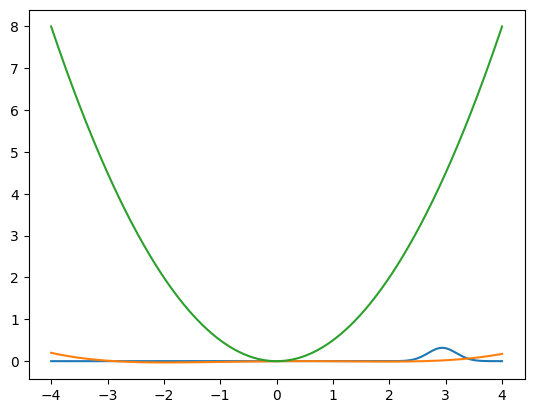

In [ ]:
plt.plot(xgrid,0.2*dis0)
pot_arr2 = pot_harmionic(xgrid,1.0,1.0)
plt.plot(xgrid,pot_arr)
plt.plot(xgrid,pot_arr2)

In [ ]:
def x2k_wave(psix):

  pre_fac = dx/(2*np.pi)**0.5
  psik = sfft.fft(psix)

  # add the phase term
  #for i in range(ndvr_x):
  #  psik[i] *= pre_fac*np.exp(-1j*(kgrid[i])*xmin)

  return psik*pre_fac

def k2x_wave(psik):

  pre_fac = (2*np.pi)**0.5/dx

  psix0 = psik.copy()
  # add the phase term
  #for i in range(ndvr_x):
  #  psix0[i] *= pre_fac*np.exp(1j*(kgrid[i])*xmin)

  psix = sfft.ifft(psix0)
  return psix*pre_fac

In [ ]:
# the potential part
def prop_wave_pot(psit):

  arrfac = np.exp(-1j*pot_arr*dt)
  psi1 = np.multiply(psit,arrfac)
  return psi1

def prop_wave_kinet(psit):

  psik0 = x2k_wave(psit)

  arrfac = np.exp(-0.5j*ak2*dt)
  psik1 = np.multiply(psik0,arrfac)

  psi1 = k2x_wave(psik1)

  return psi1


In [ ]:
dt = 1.0
nsteps = 3000
psit = psi0.copy()
xave_arr = np.zeros(nsteps)
time_arr = np.linspace(0,dt*(nsteps-1),nsteps)
dis_list = []
for istep in range(0,nsteps):
  if(istep%500==0):
    print(istep)
    dis_list.append((psit*psit.conjugate()).real)
  xave = dx*np.dot(psit.conj(),np.multiply(xgrid,psit))
  xave_arr[istep] = xave.real
  psit = prop_wave_kinet(psit)
  psit = prop_wave_pot(psit)
  psit = prop_wave_kinet(psit)

0
500
1000
1500
2000
2500


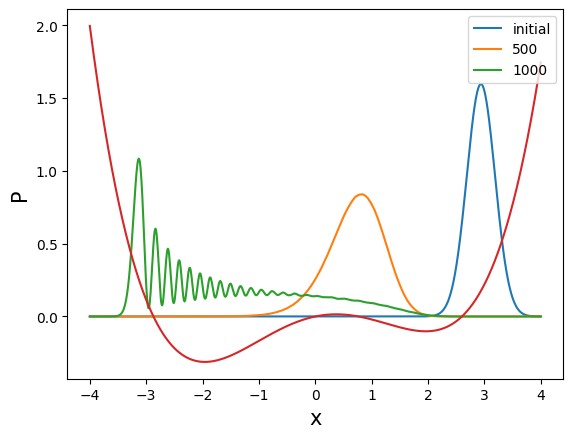

In [ ]:
plt.plot(xgrid,dis_list[0],label='initial')
plt.plot(xgrid,dis_list[1],label='500')
plt.plot(xgrid,dis_list[2],label='1000')
# plt.plot(xgrid,dis_list[3],label='1500')
# plt.plot(xgrid,dis_list[4],label='2000')
plt.plot(xgrid,pot_arr*10)
plt.xlabel('x',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc = 'upper right')

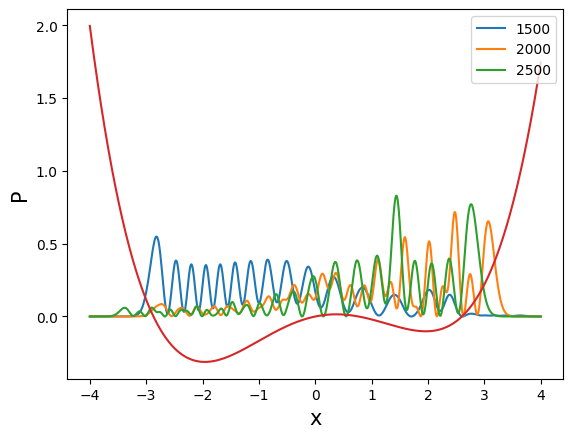

In [ ]:
plt.plot(xgrid,dis_list[3],label='1500')
plt.plot(xgrid,dis_list[4],label='2000')
plt.plot(xgrid,dis_list[5],label='2500')
plt.plot(xgrid,pot_arr*10)
plt.xlabel('x',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc = 'upper right')

In [ ]:
time_arr0 = time_arr
xave_arr0 = xave_arr

Text(0, 0.5, '$x$(t)')

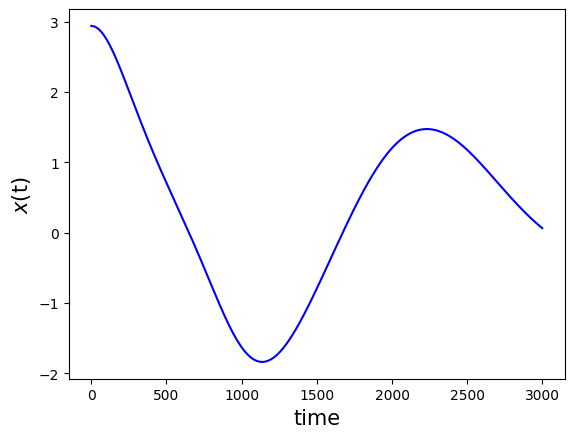

In [ ]:
plt.plot(time_arr,xave_arr,'b-')
plt.xlabel('time',fontsize=15)
plt.ylabel('$x$(t)',fontsize=15)
#plt.legend(loc = 'upper right')

In [ ]:
#try to output
import os
from google.colab import drive
drive.mount('/content/drive')

print(os.getcwd())
os.chdir('/content/drive/MyDrive')
os.listdir(os.getcwd())

Mounted at /content/drive
/content


['Fw_ Bulldog 3H_pics.zip',
 'TT-TFD + GQME_GoogleColab.ipynb',
 'GQME_Tutorial',
 'TT-TFD + GQME.ipynb',
 'CCIGQME_Tutorial_work.ipynb',
 'CCIGQME_Tutorial.ipynb',
 'CCI_partII_04',
 'FCI_H2.ipynb',
 'Quantum_tomography.ipynb',
 'aunewEspin.dat',
 'Euler_Angle.ipynb',
 'Hsemi_para.ipynb',
 'Engineering_AmplitudeDamping.ipynb']

In [ ]:
fp=open('xave.dat','w')
for i in range(nsteps):
  fp.write(f'{time_arr[i]}\t{xave_arr[i]}\n')
fp.close()

###Potential optimized propogator: use the eigen-state basis


In [ ]:
import scipy.linalg as LA
#output the eigen state for potential in x-space
#use the diag scheme
#input:kinetic hamiltonian, potential
def eig_state(hamk,pot,Nstate):

  Mata = hamk.copy()
  for i in range(ndvr_x):
    Mata[i,i]+=pot[i]

  val,arr = LA.eigh(Mata) #subset_by_index=[0:11]
  #print('TransBasis,Eigen value:',val[0:Nstate])

  ##output the eigen function and it's distribution
  #for i in range(Nstate):
  #  print('TB: Eigenval(from xTAx),enediff',i,arr[:,i].conj().T@Mata@arr[:,i],val[i+1]-val[i])

  #print('TB: eigenvec norm',LA.norm(arr[:,0]))
  #print('TB: err,',LA.norm(Mata@arr[:,0]-val[0]*arr[:,0]))

  return val[:Nstate],arr[:,:Nstate]/dx**0.5


In [ ]:
Neig = 50
eneg_G,psi_G = eig_state(hamk,pot_arr,Neig)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


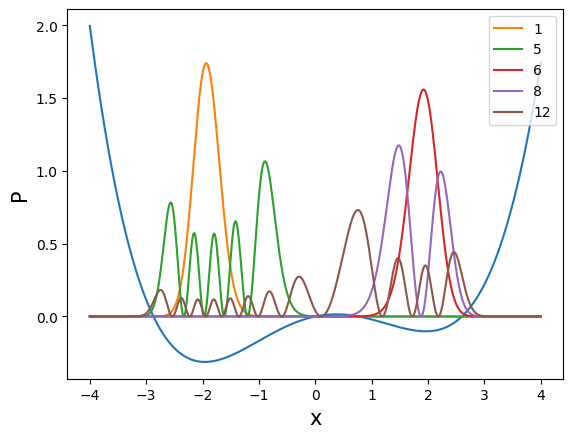

In [ ]:
dis_G = []
for i in range(Neig):
  dis_G.append(psi_G[:,i]*psi_G[:,i].conjugate().real)

plt.plot(xgrid,pot_arr*10)
plt.plot(xgrid,dis_G[0],label='1')
plt.plot(xgrid,dis_G[4],label='5')
plt.plot(xgrid,dis_G[5],label='6')
plt.plot(xgrid,dis_G[7],label='8')
plt.plot(xgrid,dis_G[11],label='12')

plt.xlabel('x',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc = 'upper right')

In [ ]:
eneg_G

array([-0.02858476, -0.02347405, -0.01855731, -0.01385891, -0.00941333,
       -0.00805144, -0.00527472, -0.00402892, -0.00154963, -0.00048043,
        0.00141175,  0.00254334,  0.00427487,  0.0060861 ,  0.0080937 ,
        0.01022964,  0.01248589,  0.01484996,  0.01731373,  0.01987054,
        0.02251493,  0.0252423 ,  0.02804867,  0.03093055,  0.03388488,
        0.03690888,  0.04000007,  0.04315617,  0.04637512,  0.049655  ,
        0.05299404,  0.05639062,  0.05984319,  0.06335034,  0.06691072,
        0.07052308,  0.07418623,  0.07789905,  0.08166047,  0.08546952,
        0.08932516,  0.09322667,  0.0971728 ,  0.1011635 ,  0.10519641,
        0.10927385,  0.11338925,  0.11755286,  0.1217439 ,  0.12599791])

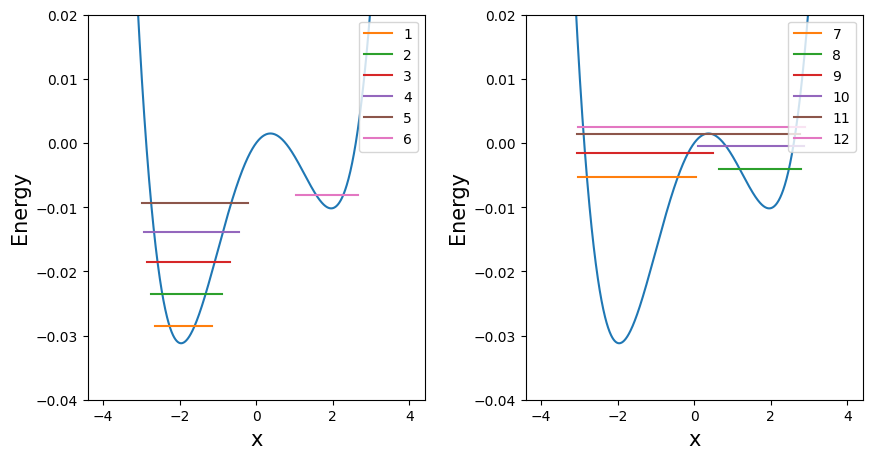

In [ ]:
x_arr1 = {}
eig_arr1 = {}

for i in range(Neig):
  x_arr1[i]=[]
  eig_arr1[i] = []
  for j in range(len(xgrid)):
    if(abs(dis_G[i][j])>1E-2):
      x_arr1[i].append(xgrid[j])
      eig_arr1[i].append(eneg_G[i])

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(xgrid,pot_arr)
for i in range(6):
  plt.plot(x_arr1[i],eig_arr1[i],label=str(i+1))

plt.ylim((-0.04, 0.02))
plt.xlabel('x',fontsize=15)
plt.ylabel('Energy',fontsize=15)
plt.legend(loc = 'upper right')

plt.subplot(122)
plt.plot(xgrid,pot_arr)
for i in range(6,12):
  plt.plot(x_arr1[i],eig_arr1[i],label=str(i+1))

plt.subplots_adjust(wspace=0.3)
plt.ylim((-0.04, 0.02))
plt.xlabel('x',fontsize=15)
plt.ylabel('Energy',fontsize=15)
plt.legend(loc = 'upper right')

In [ ]:
ini_occu = np.zeros(Neig,dtype=np.complex_)
ss = 0.0
for i in range(Neig):
  ini_occu[i] = np.dot(psi_G[:,i].conj(),psi0)*dx
  ss += (ini_occu[i]*ini_occu[i].conj()).real
  if(i%5==0): print(i,ss)

0 5.759325386675977e-27
5 0.012079983922131303
10 0.0948707212017287
15 0.3116595871321898
20 0.6070071211599841
25 0.8312468937577625
30 0.9427782385245538
35 0.9838905372987561
40 0.9960776669171321
45 0.9991467317754493


In [ ]:
Neig_array = {10,20,30,40,50}

xave_arr_eig = {}
time_arr_eig = np.linspace(0,dt*(nsteps-1),nsteps)
dis_list_eig = {}

for Neig_choose in Neig_array:
  ini_occu = np.zeros(Neig_choose,dtype=np.complex_)
  ss = 0.0
  for i in range(Neig_choose):
    ini_occu[i] = np.dot(psi_G[:,i].conj(),psi0)*dx
    ss += (ini_occu[i]*ini_occu[i].conj()).real
    #print(i,ss)

  G_dt = np.zeros((Neig_choose,Neig_choose),dtype=np.complex_)
  for i in range(Neig_choose):
    G_dt[i,i] = np.exp(-1j*eneg_G[i]*dt)

  xave_arr_eig[Neig_choose] = np.zeros(nsteps)

  dis_list_eig[Neig_choose] = []
  psit = psi_G[:,:Neig_choose]@ini_occu
  for istep in range(0,nsteps):
    if(istep%500==0):
      print(istep)
      dis_list_eig[Neig_choose].append((psit*psit.conjugate()).real)
    xave = dx*np.dot(psit.conj(),np.multiply(xgrid,psit))
    xave_arr_eig[Neig_choose][istep] = xave.real
    ini_occu = G_dt@ini_occu
    psit = psi_G[:,:Neig_choose]@ini_occu

0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500


In [ ]:
for i in Neig_array:
  print(i)

50
20
40
10
30


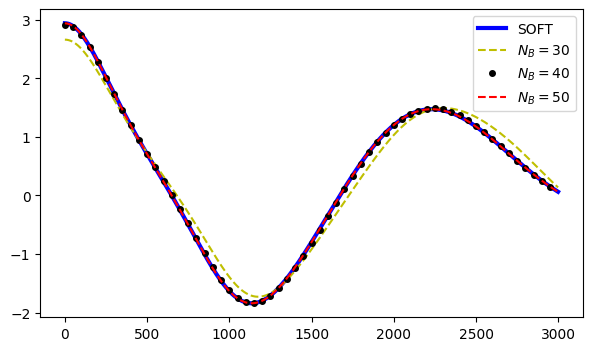

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(time_arr,xave_arr,'b-',linewidth=3.0,label = 'SOFT')
#for i in [30,40,50]:
plt.plot(time_arr_eig,xave_arr_eig[30],'y--',label ='$N_B = 30$')
plt.plot(time_arr_eig,xave_arr_eig[40],'ko',markersize=4,markevery=50,label ='$N_B = 40$')
plt.plot(time_arr_eig,xave_arr_eig[50],'r--',label ='$N_B = 50$')
plt.legend()

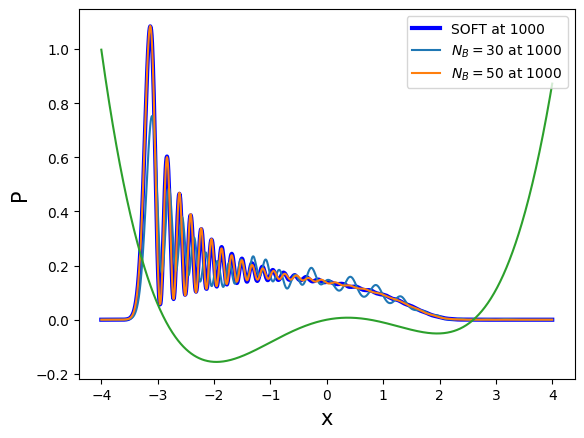

In [ ]:
plt.plot(xgrid,dis_list[2],'b-',linewidth=3.0,label='SOFT at 1000')
plt.plot(xgrid,dis_list_eig[30][2],label='$N_B = 30$ at 1000')
#plt.plot(xgrid,dis_list_eig[40][2],label='$N_B = 40$ at 1000')
plt.plot(xgrid,dis_list_eig[50][2],label='$N_B = 50$ at 1000')
plt.plot(xgrid,pot_arr*5)
plt.xlabel('x',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc = 'upper right')

### Eigenstate basis do the density matrix evolution

In [ ]:
import scipy.linalg as LA
#output the eigen state for potential in x-space
#use the diag scheme
#input:kinetic hamiltonian, potential
def eig_state(hamk,pot,Nstate):

  Mata = hamk.copy()
  for i in range(ndvr_x):
    Mata[i,i]+=pot[i]

  val,arr = LA.eigh(Mata) #subset_by_index=[0:11]
  #print('TransBasis,Eigen value:',val[0:Nstate])

  ##output the eigen function and it's distribution
  #for i in range(Nstate):
  #  print('TB: Eigenval(from xTAx),enediff',i,arr[:,i].conj().T@Mata@arr[:,i],val[i+1]-val[i])

  #print('TB: eigenvec norm',LA.norm(arr[:,0]))
  #print('TB: err,',LA.norm(Mata@arr[:,0]-val[0]*arr[:,0]))

  return val[:Nstate],arr[:,:Nstate]/dx**0.5


In [ ]:
Neig = 50
eneg_G,psi_G = eig_state(hamk,pot_arr,Neig)

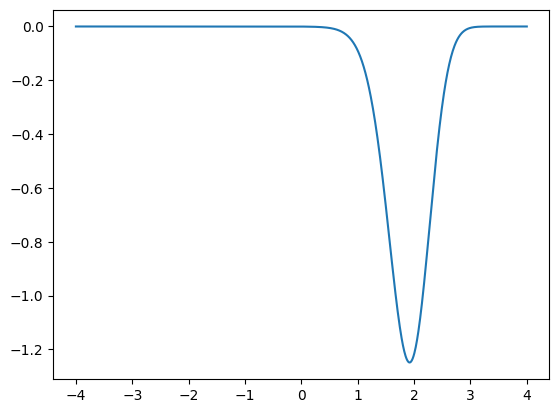

In [ ]:
plt.plot(xgrid,psi_G[:,5])

In [ ]:
psik_G = np.zeros((ndvr_x,Neig),dtype=np.complex_)
for i in range(Neig):
  psik_G[:,i] = x2k_wave(psi_G[:,i])

In [ ]:
#The matrix in the eigenstate
xmat_eig = np.zeros((Neig,Neig),dtype=np.complex_)
pmat_eig = np.zeros((Neig,Neig),dtype=np.complex_)
for i in range(Neig):
  for j in range(Neig):
    xmat_eig[i,j] = np.dot(np.multiply(psi_G[:,i].conj(),xgrid),psi_G[:,j])*dx
    pmat_eig[i,j] = np.dot(np.multiply(psik_G[:,i].conj(),kgrid),psik_G[:,j])*dk

In [ ]:
ini_occu = np.zeros(Neig,dtype=np.complex_)
#ini_occu[5] = 1.0
ss = 0.0
for i in range(Neig):
  ini_occu[i] = np.dot(psi_G[:,i].conj(),psi0)*dx
  ss += (ini_occu[i]*ini_occu[i].conj()).real
  if((i+1)%5==0): print(i+1,ss)

5 4.899061260000359e-13
10 0.0879411119644512
15 0.2574801842084356
20 0.5497026350427312
25 0.7960013742226377
30 0.9277880686379576
35 0.9789755396948184
40 0.9947447432033308
45 0.9988338294049449
50 0.9997619920136338


In [ ]:
rho0 = np.outer(ini_occu,ini_occu.conj())
H_dw = np.diag(eneg_G)
time_arr_no = np.linspace(0,3*(1000-1),1000)
result_no = mesolve(Qobj(H_dw), Qobj(rho0), time_arr_no, [], Qobj(xmat_eig), progress_bar=True)

10.0%. Run time:   3.93s. Est. time left: 00:00:00:35
20.0%. Run time:  10.01s. Est. time left: 00:00:00:40
30.0%. Run time:  13.77s. Est. time left: 00:00:00:32
40.0%. Run time:  17.20s. Est. time left: 00:00:00:25
50.1%. Run time:  19.38s. Est. time left: 00:00:00:19
60.1%. Run time:  22.33s. Est. time left: 00:00:00:14
70.1%. Run time:  25.30s. Est. time left: 00:00:00:10
80.1%. Run time:  27.47s. Est. time left: 00:00:00:06
90.1%. Run time:  29.65s. Est. time left: 00:00:00:03
100.0%. Run time:  31.81s. Est. time left: 00:00:00:00
Total run time:  31.81s


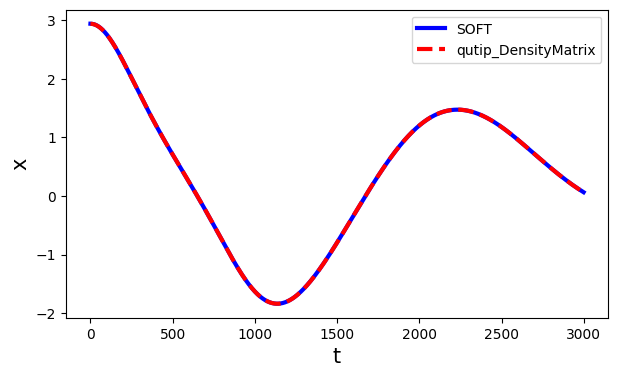

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(np.linspace(0,dt*(nsteps-1),nsteps),xave_arr,'b-',linewidth=3.0,label = 'SOFT')
plt.plot(time_arr_no,result_no.expect[0][:],'r--',linewidth=3.0,label = 'qutip_DensityMatrix')
plt.xlabel('t',fontsize=15)
plt.ylabel('x',fontsize=15)
plt.legend(loc = 'upper right')

In [ ]:
amat_eig = (xmat_eig.copy()+1j*pmat_eig.copy())/np.sqrt(2)
adegmat_eig = (xmat_eig.copy()-1j*pmat_eig.copy())/np.sqrt(2)
kappa = 0.1**3; nth = 0.1
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))
time_arr = np.linspace(0,1*3000,3000)
c_ops = [gamma1*Qobj(amat_eig), gamma2*Qobj(adegmat_eig)]

In [ ]:
result = mesolve(Qobj(H_dw), Qobj(rho0), time_arr, c_ops, Qobj(xmat_eig),progress_bar=True, options={'store_states':True})

10.0%. Run time:   3.71s. Est. time left: 00:00:00:33
20.0%. Run time:   6.51s. Est. time left: 00:00:00:26
30.0%. Run time:  11.09s. Est. time left: 00:00:00:25
40.0%. Run time:  13.97s. Est. time left: 00:00:00:20
50.0%. Run time:  17.18s. Est. time left: 00:00:00:17
60.0%. Run time:  20.52s. Est. time left: 00:00:00:13
70.0%. Run time:  25.31s. Est. time left: 00:00:00:10
80.0%. Run time:  28.61s. Est. time left: 00:00:00:07
90.0%. Run time:  32.49s. Est. time left: 00:00:00:03
100.0%. Run time:  36.21s. Est. time left: 00:00:00:00
Total run time:  36.22s


In [ ]:
result.states[0].full()

array([[ 5.75932539e-27+4.41972318e-44j, -3.25602147e-27-8.37975903e-28j,
         7.03457269e-25+1.21064133e-25j, ...,
         9.73378424e-16+1.67482037e-16j,  8.34565227e-16+1.43597475e-16j,
         7.09446400e-16+1.22069203e-16j],
       [-3.25602147e-27+8.37975903e-28j,  1.96270894e-27-5.35273314e-45j,
        -4.15312669e-25+3.39089756e-26j, ...,
        -5.74665735e-16+4.69399692e-17j, -4.92712832e-16+4.02458747e-17j,
        -4.18844847e-16+3.42121742e-17j],
       [ 7.03457269e-25-1.21064133e-25j, -4.15312669e-25-3.39089756e-26j,
         8.84667248e-23-1.67294113e-43j, ...,
         1.22411246e-13-4.29889300e-18j,  1.04954216e-13-3.68582908e-18j,
         8.92193781e-14-3.13324603e-18j],
       ...,
       [ 9.73378424e-16-1.67482037e-16j, -5.74665735e-16-4.69399692e-17j,
         1.22411246e-13+4.29889300e-18j, ...,
         1.69380218e-04-6.30206374e-33j,  1.45224957e-04+1.50863121e-16j,
         1.23452691e-04+1.05592925e-16j],
       [ 8.34565227e-16-1.43597475e-16j, -4.

In [ ]:
psi_G.T.shape

(50, 1024)

In [ ]:
dis_list2 = []
for nn in [500,1000,2000,2500,2999]:
  rho = result.states[nn].full()
  rho_grid = np.matmul(np.matmul(psi_G,rho),psi_G.conj().T)
  dis_list2.append(rho_grid.diagonal())

In [ ]:
for nn in [500,1000]:
  print(nn)

500
1000


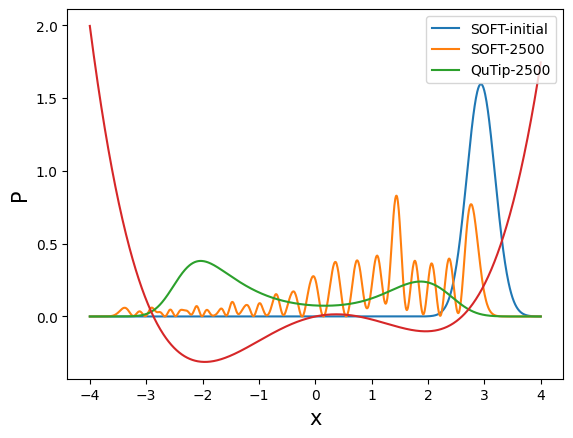

In [ ]:
plt.plot(xgrid,dis_list[0],label='SOFT-initial')
#plt.plot(xgrid,dis_list[1],label='SOFT-500')
#plt.plot(xgrid,dis_list[2],label='SOFT-1000')
#plt.plot(xgrid,dis_list[4],label='SOFT-2000')
plt.plot(xgrid,dis_list[5],label='SOFT-2500')

#plt.plot(xgrid,dis_list2[0],label='QuTip-500')
#plt.plot(xgrid,dis_list2[1],label='QuTip-1000')
plt.plot(xgrid,dis_list2[3],label='QuTip-2500')
# plt.plot(xgrid,dis_list[3],label='1500')
# plt.plot(xgrid,dis_list[4],label='2000')
plt.plot(xgrid,pot_arr*10)
plt.xlabel('x',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc = 'upper right')

In [ ]:
3000*au2fs

NameError: name 'au2fs' is not defined

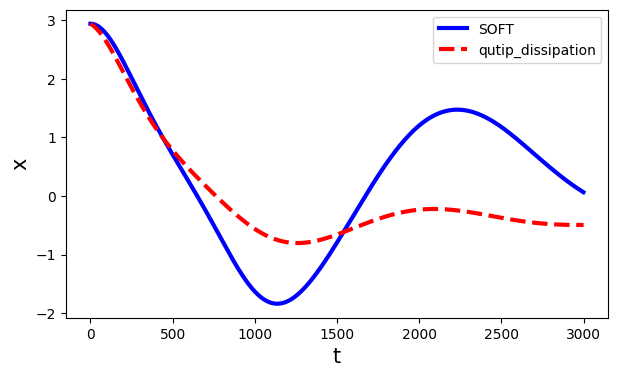

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(np.linspace(0,dt*(3000-1),3000),xave_arr[:],'b-',linewidth=3.0,label = 'SOFT')
#plt.plot(time_arr_no,result_no.expect[0][:],'b-',linewidth=3.0,label = 'qutip_Liouville')
plt.plot(time_arr,result.expect[0][:],'r--',linewidth=3.0,label = 'qutip_dissipation')
plt.xlabel('t',fontsize=15)
plt.ylabel('x',fontsize=15)
plt.legend(loc = 'upper right')

# Simulating the Lindblad Master Equation on Quantum Computers

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

dilation

In [ ]:
def dilate(array):

  # Normalization factor, 1.1 times martix's norm to ensure contraction
  norm = LA.norm(array,2)*1.1
  array_new = array/norm

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])

  return array_dilated, norm

## The Spin-1/2 system: Amplitude-channel damping

In [ ]:
Nsys_1spin = 2
#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
vec0_sdam0 = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam0,2)
vec0_sdam0 /= norm0_sdam
print(norm0_sdam)

0.8660254037844386


In [ ]:
vec0_sdam0

array([0.28867513+0.j, 0.28867513+0.j, 0.28867513+0.j, 0.8660254 +0.j])

In [ ]:
(0.25**2*3+0.75**2)**0.5

0.8660254037844386

In [ ]:
LA.norm(vec0_sdam0,2)

0.8660254037844386

In [ ]:
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps
Nsys_1spin = 2

#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
vec0_sdam = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam,2)
vec0_sdam /= norm0_sdam

ident_h = np.eye(Nsys_1spin, dtype = np.complex_)
Amat = np.zeros((Nsys_1spin**2,Nsys_1spin**2),dtype=np.complex_)

#matrix for time-derivation of the vectorized density matrix
Amat += 0.5*gamma*(2*(np.kron(sigmap,sigmap.conj())) - np.kron(ident_h, sigmap.T@sigmap.conj()) - np.kron(sigmap.T.conj()@sigmap,ident_h))

Pop_Mexp = np.zeros((2,len(time_sdam)),dtype=np.float_) #population array

Gprop_sdam = []
for i in range(len(time_sdam)):

  Gt = LA.expm(Amat*time_sdam[i])
  Gprop_sdam.append(Gt)

  rhot_sdam = (Gt@vec0_sdam).reshape(Nsys_1spin,Nsys_1spin)*norm0_sdam
  Pop_Mexp[0,i] = rhot_sdam[0,0].real
  Pop_Mexp[1,i] = rhot_sdam[1,1].real

In [ ]:
# initial state in the dilated space
rho0_sdam_dil = np.concatenate((vec0_sdam,np.zeros(Nsys_1spin**2)))

aersim = AerSimulator()
shots = 2000
Pop_qc = np.zeros((2,len(time_sdam)),dtype=np.float_)

for i in range(len(time_sdam)):
    if(i%100==0):print('istep',i)
    qr = QuantumRegister(2+1)  # Create a quantum register
    cr = ClassicalRegister(2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sdam_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sdam[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)
    # Apply the unitary operator to the quantum circuit's qubits and measure
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)

    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    if '011' and '000' in counts1:
      Pop_qc[0,i] = np.sqrt(counts1['000']/shots)*norm*norm0_sdam
      Pop_qc[1,i] = np.sqrt(counts1['011']/shots)*norm*norm0_sdam
    else:
      print(i,'shots=',shots,"no counts for up state")


istep 0
istep 100
istep 200
istep 300
istep 400
istep 500
istep 600
istep 700
istep 800
istep 900


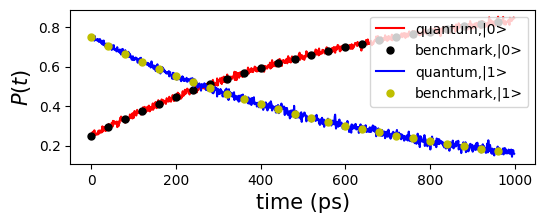

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_sdam,Pop_qc[0,:],'r-',label="quantum,|0>")
plt.plot(time_sdam,Pop_Mexp[0,:],'ko',markersize=5,markevery=40,label="benchmark,|0>")
plt.plot(time_sdam,Pop_qc[1,:],'b-',label="quantum,|1>")
plt.plot(time_sdam,Pop_Mexp[1,:],'yo',markersize=5,markevery=40,label="benchmark,|1>")
plt.xlabel('time (ps)',fontsize=15)
plt.ylabel('$P(t)$',fontsize=15)
plt.legend(loc = 'upper right')

## The spin chain

In [ ]:
# initial state of the spin chain in the dilated space
# rho0_sc=|up,down,...><up,down,...|, has defined in the Digital computer simulation part
rho0_sc_dil = np.concatenate((rho0_sc.reshape(Nsys_sc**2),np.zeros(Nsys_sc**2)))

aersim=AerSimulator()
shots_arr = [1000,10000]
As_qc = np.zeros((len(shots_arr),nsteps),dtype=np.float_)

for i in range(nsteps):
    if(i%10==0):print('istep',i)
    qr = QuantumRegister(nsite*2+1)  # Create a quantum register
    cr = ClassicalRegister(nsite*2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sc_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sc[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)

    qc.measure(qr, cr)

    for ishot in range(len(shots_arr)):
        counts1 = aersim.run(qc,shots=shots_arr[ishot]).result().get_counts()
        if '0011011' in counts1:
          survi_amp = np.sqrt(counts1['0011011']/shots_arr[ishot])*norm
          As_qc[ishot,i] = np.sqrt(survi_amp)
        else:
          print(i,'shots=',shots_arr[ishot],"no counts")


istep 0
istep 10
istep 20
istep 30
istep 40
istep 50
istep 60
istep 70
istep 80
istep 90
istep 100
istep 110
istep 120
istep 130
istep 140
istep 150
istep 160
istep 170
istep 180
istep 190
istep 200
istep 210
istep 220
istep 230
istep 240


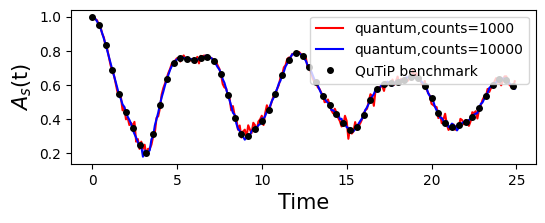

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_qc[0][:],'r-',label=f"quantum,counts={shots_arr[0]}")
plt.plot(time_arr,As_qc[1][:],'b-',label=f"quantum,counts={shots_arr[1]}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

In [ ]:
qc.decompose().depth()

14514

# Reference: (Yuchen) Simulating amplitude channel damping with Kraus Operators


## Defining the initial state and the Kraus operators

In [ ]:
#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps

iden = np.eye(2)
iden2 = np.eye(4)

#flattening or vectorize the density matrix
rho_norm=LA.norm(rho0_sdam)
rho_flat= rho0_sdam.flatten()/rho_norm

#defining the Kraus operators
def k_0(x):
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k

## Defining function for 2-dialation

In [ ]:
#defining the function for dilation
def udil(k):
#first and second stands for the M and N, i.e. Kraus and its complex conjugate
    first= np.kron(k,iden)
    kc=k.conjugate()  #complex conjugate of k
    second= np.kron(iden,kc)
    fcon = (first.conjugate()).T
    scon = (second.conjugate()).T
    #calculate the defect operators of each Kraus operators
    fdef = LA.sqrtm(iden2-np.dot(fcon,first))
    sdef = LA.sqrtm(iden2 -np.dot(scon,second))
    fcondef = LA.sqrtm(iden2-np.dot(first,fcon))
    scondef = LA.sqrtm(iden2-np.dot(second,scon))
    #2-dilation process
    Ufirst= np.block([[first, np.zeros((4,4)),fcondef,np.zeros((4,4))],
    [fdef,np.zeros((4,4)),-fcon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    Usecond=np.block([[second, np.zeros((4,4)),scondef,np.zeros((4,4))],
    [sdef,np.zeros((4,4)),-scon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    ufre=np.reshape(Ufirst,(1,256))
    usec=np.reshape(Usecond,(1,256))
    #returning the unitaries for both the Kraus operator and its complex conjugate
    return ufre,usec

## QASM simulation with Qiskit package

In [ ]:
#defining lists used to store the results
rho_at_t=np.zeros((1000,2), "complex")
time=np.zeros((1000,1),)
udil01=np.zeros((1000,256),"complex")
udil02=np.zeros((1000,256),"complex")
udil11=np.zeros((1000,256),"complex")
udil12=np.zeros((1000,256),"complex")
# assigning the time-steps
for t in range(0,1000):
    tt=t
    k0=k_0(tt)
    k1=k_1(tt)
    udil01[t],udil02[t] = udil(k0)
    udil11[t],udil12[t] = udil(k1)

shots = 2000
#create dictionaries to store the results. three binary digits due to 8*8 matrix needs three qubits
result = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0}
result2 = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0}
p_excited = []# create list to store probability for acceptor state
p_ground = []# create list to store probability for donor state

# Below are the loop of the QASM simulation
aersim=AerSimulator()
for i in range (0,1000):
    #for Kraus operator 1
    U1first=np.reshape(udil01[i],(16,16))
    U1second=np.reshape(udil02[i],(16,16))
    # qiskit quantum circuit generation process
    initial_state = np.concatenate([rho_flat,np.zeros(12)])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, qr)
    # generating self-defined quantum gates with dilated unitaries
    A = Operator(U1first)
    B = Operator(U1second)
    U_G_op = A.compose(B)
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)
    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    for x in counts1:
        result[x] = counts1[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg1 = np.sqrt(result['0000'] / 2000)*rho_norm
    pe1 =  np.sqrt(result['0011'] / 2000)*rho_norm
    #for Kraus operator 2
    U2first=np.reshape(udil11[i],(16,16))
    U2second=np.reshape(udil12[i],(16,16))
    initial_state2 = np.concatenate([rho_flat,np.zeros(12)])
    qr2 = QuantumRegister(4)
    cr2 = ClassicalRegister(4)
    qc2 = QuantumCircuit(qr2, cr2)
    qc2.initialize(initial_state, qr2)
    C = Operator(U2first)
    D = Operator(U2second)
    U_G_op2 = C.compose(D)
    qc2.unitary(U_G_op2, qr2)
    qc2.measure(qr2, cr2)
    counts2 = aersim.run(qc2, shots=shots).result().get_counts()
    for x in counts2:
        result2[x] = counts2[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg2 = np.sqrt(result2['0000'] / 2000)*rho_norm
    pe2 =  np.sqrt(result2['0011'] / 2000)*rho_norm
    pe=pe1+pe2
    pg=pg1+pg2
    p_excited.append(pe)
    p_ground.append(pg)

## Ploting the simulation results

check the corretness

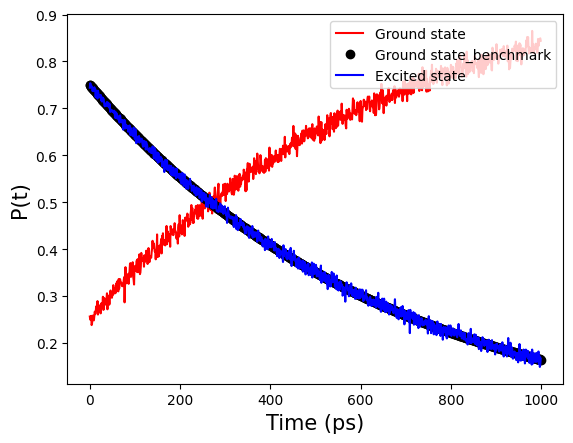

In [ ]:
#plotting the QASM simulation results
plt.plot(time_sdam, p_ground, 'r-', label="Ground state")
plt.plot(time_sdam, Pop_Mexp[1,:], 'ko', label="Ground state_benchmark")
plt.plot(time_sdam, p_excited, 'b-', label='Excited state')
plt.xlabel('Time (ps)',fontsize=15)
plt.ylabel('P(t)',fontsize=15)
plt.legend(loc = 'upper right')